# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparation du jeu de données](#init)
    * [1.1 Séparation du jeu de données en `train`, `valid` et `test` sets](#NLP_split)
    * [1.2 Création du Corpus Bag-Of-Words](#NLP_corpus_bow)
    * [1.3 Création du Corpus TF-IDF](#NLP_corpus_tfidf)
* [2. Recherche du `modèle` de classification le plus adapté](#CLF)
    * [2.1 DummyClassifier](#CLF_dummy)
    * [2.2 LogisticRegression](#CLF_logreg)
* [3. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [3.1 Tokenisation](#PREPROCESS_tokenized)
    * [3.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [3.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [3.4 Comparaison des scores](#PREPROCESS_scores)
* [4. Recherche du `plongement` le plus adapté](#EMBEDDING)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
keras.utils.set_random_seed(random_seed)

2022-07-29 01:40:58.323416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 01:40:58.323442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [3]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN.csv")

#### Définissons une méthode de `cross-validation`

In [4]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Définissons les fonctions génériques de notre Spot Checking 

In [5]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [6]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=6,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

In [7]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()

---
---
# 3. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [8]:
def architecture1(f_opti, f_loss, f_metrics, embedding):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

---
## 3.1 Jeu de données BRUT (RAW) <a class="anchor" id="PREPROCESS_tokenized"></a> [⇪](#menu)

### Chargeons le jeu de données brut (RAW) pour nos premiers essais

In [9]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [10]:
sample_size = 10000
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [11]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1303215,"[@RichGolisch, Thanks!]",1
1121114,"[Trying, to, get, a, babysitter, and, be, 999,...",1


(10000, 2)

In [12]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_raw'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [13]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=2000, padding_size=35, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}")
        print(f">> X_train_enc: {X_train_enc[:1]}")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

In [14]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ["trying out a new restaurant tonight, spot i'm excited!"]
>> X_train_enc: [[203, 31, 4, 70, 1638, 803, 1639, 17, 1263]]
>> X_train_ready: [[ 203   31    4   70 1638  803 1639   17 1263    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 22516


### Entrainons notre Neural Network 

In [15]:
# w2v_embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=False)
embedding = layers.Embedding(vocab_size, 256)

In [16]:
archi01_model_RAW = architecture1(f_opti, f_loss, f_metrics, embedding)

2022-07-29 01:41:02.525778: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 01:41:02.525806: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 01:41:02.525827: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist
2022-07-29 01:41:02.526055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
archi01_model_RAW.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5764096   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         229504    
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                             

In [18]:
t0 = time.perf_counter()
history_clf_archi01_RAW = archi01_model_RAW.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5644
Epoch 1: val_accuracy improved from -inf to 0.67850, saving model to models/archi01_RAW.epoch01-accuracy0.68.hdf5
250/250 [==============================] - 15s 57ms/step - loss: 0.6768 - accuracy: 0.5644 - val_loss: 0.6113 - val_accuracy: 0.6785 - lr: 5.0000e-04
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.5542 - accuracy: 0.7203
Epoch 2: val_accuracy improved from 0.67850 to 0.71500, saving model to models/archi01_RAW.epoch02-accuracy0.71.hdf5
250/250 [==============================] - 14s 56ms/step - loss: 0.5543 - accuracy: 0.7204 - val_loss: 0.5615 - val_accuracy: 0.7150 - lr: 5.0000e-04
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8110
Epoch 3: val_accuracy did not improve from 0.71500
250/250 [==============================] - 14s 55ms/step - loss: 0.4211 - accuracy: 0.8110 - val_loss: 0.5999 - val_accuracy: 0.70

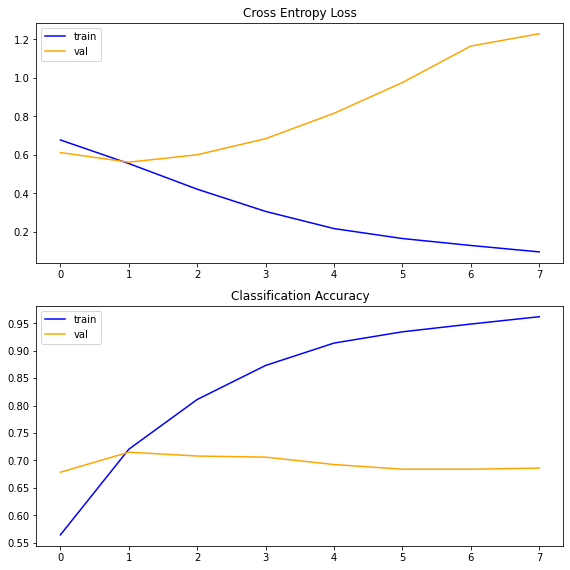

In [19]:
summarize_diagnostics(history_clf_archi01_RAW)

### Affichons les scores du modèle

In [20]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

63/63 [==============================] - 0s 3ms/step


(2000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + TF-IDF) ----------------------------------------------------------------------

             ROC_AUC : 0.7901
                  F1 : 0.7273
            ACCURACY : 0.7150
           PRECISION : 0.6828
              RECALL : 0.7779
   AVERAGE_PRECISION : 0.7772

       TRAINING-TIME : 112.1012
      INFERENCE-TIME : 0.3388

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.65      0.70      1023
Prediction = 1       0.68      0.78      0.73       977

      accuracy                           0.71      2000
     macro avg      

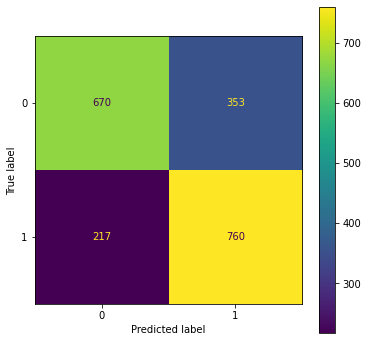

--- ROC AUC ---------------------------------------------------------------------------------------- 



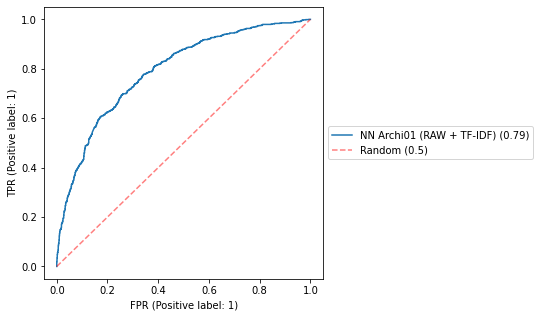

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



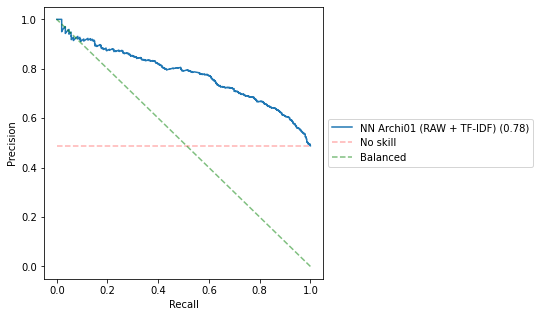

In [21]:
model_name = "NN Archi01 (RAW + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.2 TOKENISATION + FILTRAGE <a class="anchor" id="PREPROCESS_filtered"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré

In [22]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
data_nlp = joblib.load(data_nlp_path)

In [23]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [24]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_filtered,target
33683,"[wretched, weather, note, washed, car]",0
1346934,"[congrats, man, looks, like, fierce, eyes]",1


(10000, 2)

In [25]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_filtered'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [26]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['love getting calls extended family year old computers expect fix']
>> X_train_enc: [[9, 46, 636, 1063, 163, 86, 100, 1761, 1226, 432]]
>> X_train_ready: [[   9   46  636 1063  163   86  100 1761 1226  432    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 9409


### Entrainons notre Neural Network 

In [27]:
# w2v_embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=False)
embedding = layers.Embedding(vocab_size, 256)

In [28]:
archi01_model_FILTERED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [29]:
archi01_model_FILTERED.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2408704   
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         229504    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [30]:
t0 = time.perf_counter()
history_clf_archi01_FILTERED = archi01_model_FILTERED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_FILTERED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5130
Epoch 1: val_accuracy improved from -inf to 0.52100, saving model to models/archi01_FILTERED.epoch01-accuracy0.52.hdf5
250/250 [==============================] - 8s 29ms/step - loss: 0.6930 - accuracy: 0.5130 - val_loss: 0.6928 - val_accuracy: 0.5210 - lr: 5.0000e-05
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.5128
Epoch 2: val_accuracy did not improve from 0.52100
250/250 [==============================] - 7s 28ms/step - loss: 0.6926 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4850 - lr: 5.0000e-05
Epoch 3/50
249/250 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.5240
Epoch 3: val_accuracy did not improve from 0.52100
250/250 [==============================] - 7s 28ms/step - loss: 0.6918 - accuracy: 0.5241 - val_loss: 0.6931 - val_accuracy: 0.4850 - lr: 5.0000e-05
Epoch 4/50
250/250 [========================

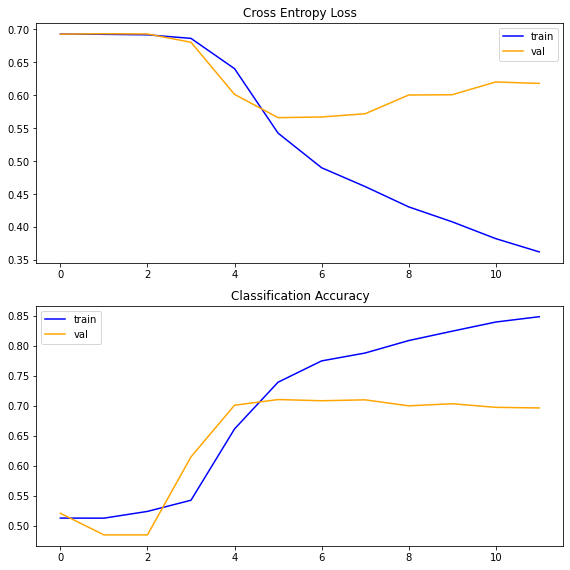

In [31]:
summarize_diagnostics(history_clf_archi01_FILTERED)

### Affichons les scores du modèle

In [32]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_FILTERED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

63/63 [==============================] - 0s 3ms/step


(2000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (FILTERED + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.7793
                  F1 : 0.7386
            ACCURACY : 0.7105
           PRECISION : 0.6903
              RECALL : 0.7942
   AVERAGE_PRECISION : 0.7703

       TRAINING-TIME : 86.3824
      INFERENCE-TIME : 0.2788

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.62      0.68       970
Prediction = 1       0.69      0.79      0.74      1030

      accuracy                           0.71      2000
     macro avg       

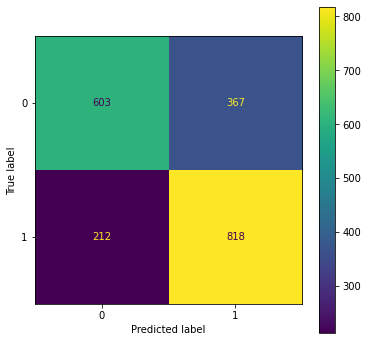

--- ROC AUC ---------------------------------------------------------------------------------------- 



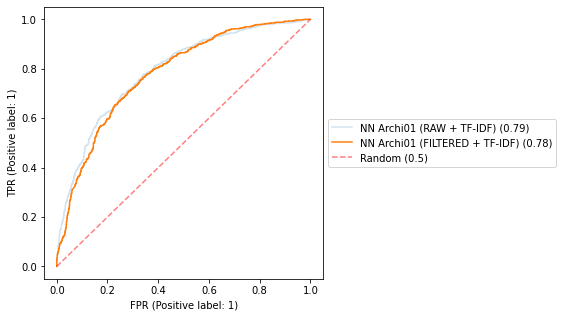

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



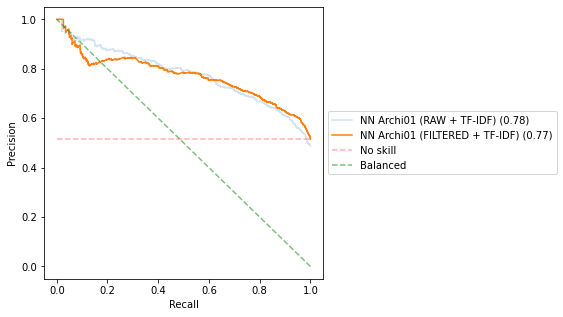

In [33]:
model_name = "NN Archi01 (FILTERED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.3 TOKENISATION + FILTRAGE + LEMMATIZATION <a class="anchor" id="PREPROCESS_lemmatized"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré & lemmatisé

In [34]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp = joblib.load(data_nlp_path)

In [35]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [36]:
display(data_nlp.head(2), data_nlp.shape)

,lemmas,target
33683,"[wretched, weather, note, wash, car]",0
1346934,"[congrat, man, look, like, fierce, eye]",1


(10000, 2)

In [37]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['lemmas'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [38]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['love get call extended family year old computer expect fix']
>> X_train_enc: [[8, 5, 115, 972, 162, 75, 104, 240, 500, 277]]
>> X_train_ready: [[  8   5 115 972 162  75 104 240 500 277   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 7809


### Entrainons notre Neural Network 

In [39]:
# w2v_embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=False)
embedding = layers.Embedding(vocab_size, 256)

In [40]:
archi01_model_LEMMATIZED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [41]:
archi01_model_LEMMATIZED.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         1999104   
                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         229504    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                           

In [42]:
t0 = time.perf_counter()
history_clf_archi01_LEMMATIZED = archi01_model_LEMMATIZED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_LEMMATIZED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
248/250 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5026
Epoch 1: val_accuracy improved from -inf to 0.48500, saving model to models/archi01_LEMMATIZED.epoch01-accuracy0.49.hdf5
250/250 [==============================] - 7s 25ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6934 - val_accuracy: 0.4850 - lr: 5.0000e-06
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5108
Epoch 2: val_accuracy did not improve from 0.48500
250/250 [==============================] - 6s 24ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6935 - val_accuracy: 0.4850 - lr: 5.0000e-06
Epoch 3/50
248/250 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5098
Epoch 3: val_accuracy did not improve from 0.48500
250/250 [==============================] - 6s 23ms/step - loss: 0.6928 - accuracy: 0.5102 - val_loss: 0.6937 - val_accuracy: 0.4850 - lr: 5.0000e-06
Epoch 4/50
250/250 [======================

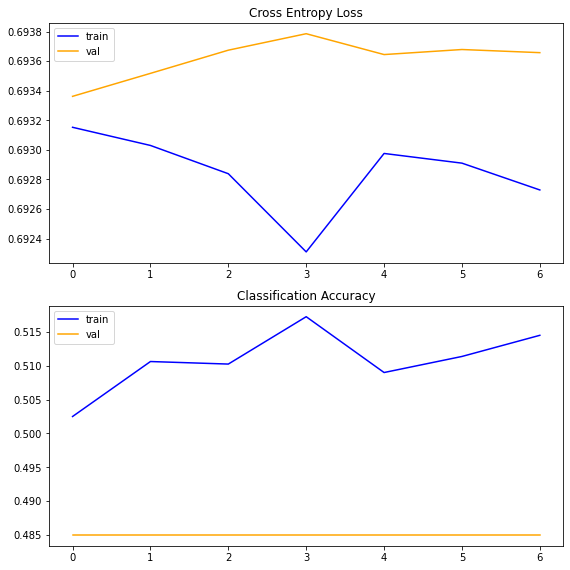

In [43]:
summarize_diagnostics(history_clf_archi01_LEMMATIZED)

### Affichons les scores du modèle

In [44]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_LEMMATIZED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

63/63 [==============================] - 0s 3ms/step


(2000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (LEMMATIZED + TF-IDF) ---------------------------------------------------------------

             ROC_AUC : 0.5289
                  F1 : 0.0000
            ACCURACY : 0.4850
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.5255

       TRAINING-TIME : 41.5821
      INFERENCE-TIME : 0.2981

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.48      1.00      0.65       970
Prediction = 1       0.00      0.00      0.00      1030

      accuracy                           0.48      2000
     macro avg       

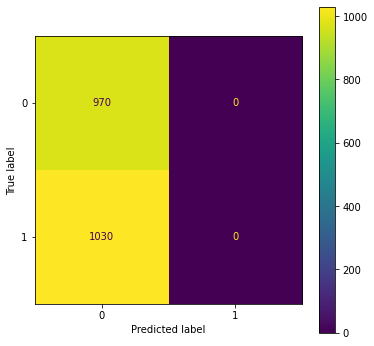

--- ROC AUC ---------------------------------------------------------------------------------------- 



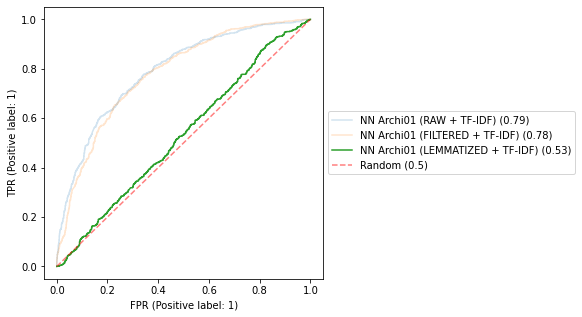

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



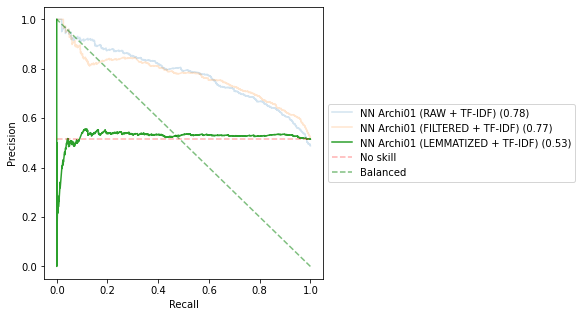

In [45]:
model_name = "NN Archi01 (LEMMATIZED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.4 Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [46]:
from classification_utils import scores_df

In [47]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.790145,0.777240,0.727273,0.7150,0.682839,0.777892,760,670,353,217,112.101167,0.338816
1,NN Archi01 (FILTERED + TF-IDF),None,None,0.779269,0.770264,0.738600,0.7105,0.690295,0.794175,818,603,367,212,86.382437,0.278791
2,NN Archi01 (LEMMATIZED + TF-IDF),None,None,0.528920,0.525478,0.000000,0.4850,0.000000,0.000000,0,970,0,1030,41.582103,0.298146


# 4. Plongements

> https://fr.wikipedia.org/wiki/Word_embedding
>
> Pour utiliser les données en apprentissage machine, il est nécessaire de leur trouver une représentation mathématique, typiquement des vecteurs. Certaines données s'y prêtent directement, comme par exemple les images, qui engendrent des vecteurs riches en information, encodant toutes les nuances et les couleurs qui les composent. Les mots, quant à eux, sont des éléments d'information isolés, et certaines représentations rudimentaires se limitent à un simple identifiant par mot. Par exemple le mot « chat » sera encodé par un seul identifiant arbitraire, disons X87. C'est une représentation discrète, relativement pauvre, qui ne permet notamment pas de comparer deux mots entre eux5. Les plongements lexicaux, eux, représentent un mot par un vecteur. Par exemple, un chat sera représenté par le vecteur [0,43 0,88 0,98 1,3]. Si l'on encode tous les mots d'un dictionnaire ainsi, il devient alors **possible de comparer les vecteurs des mots entre eux**, par exemple en mesurant l'angle entre les vecteurs. Une bonne représentation de mots permettra alors de trouver que le mot « chien » est plus près du mot « chat » qu'il ne l'est du mot « gratte-ciel »6. Qui plus est, ces représentations permettent d'espérer que, dans l'espace vectoriel où le plongement est fait, on aura l'équation roi - homme + femme = reine ou encore l'équation Paris - France + Pologne = Varsovie7.
> 
> Les plongements lexicaux sont également très **utiles pour mitiger le fléau de la dimension**, un problème récurrent en intelligence artificielle. Sans les plongements de mots, **les identifiants uniques représentant les mots engendrent des données éparses**, des points isolés dans un espace vaste et presque vide6. Avec les plongements de mots, en revanche, l'espace devient beaucoup plus restreint et il est plus facile pour un ordinateur d'y établir des regroupements, d'y découvrir des régularités, en apprentissage machine. 

In [48]:
from gensim.models import Word2Vec, FastText

In [ ]:
w2v_model = Word2Vec(df_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [ ]:
pretrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in w2v_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.wv.most_similar(word)[:8])
        print(f'{word} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

In [ ]:
ft_model = FastText(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [ ]:
def word_embedding_transform(embedding_model, sentences, max_len=50):

    print('\nPreparing the data for Keras NN...')
    train_x = np.zeros([len(sentences), max_len], dtype=np.int32)
    for i, (id,sentence) in enumerate(sentences.iteritems()):
        for t, word in enumerate(sentence[:-1]):
            if word in embedding_model.wv:
                train_x[i, t] = w2v_model.wv.key_to_index[word]
                
    return train_x

In [ ]:
train_x = word_embedding_transform(w2v_model, df_train)
train_y = y_train

print('train_x shape:', train_x.shape, 'train_y shape:', train_y.shape)

valid_x = word_embedding_transform(w2v_model, df_test)
valid_y = y_test

print('valid_x shape:', valid_x.shape, 'valid_y shape:', valid_y.shape)

In [ ]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer